In [55]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
# from voltron.robinhood_utils import GetStockData
import os
# import robin_stocks.robinhood as r
import pickle5 as pickle

sns.set_style('white')
# style.use('whitegrid')
palette = ["#1b4079", "#C6DDF0", "#048A81", "#B9E28C", "#8C2155", "#AF7595", "#E6480F", "#FA9500"]
sns.set(palette = palette, font_scale=2.0, style="white", rc={"lines.linewidth": 4.0})


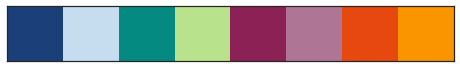

In [56]:
sns.palplot(palette)

In [57]:
with open("../../spdr-data/XLF.pkl", "rb") as handle:
    finance_data = pickle.load(handle)
with open("../../spdr-data/XLE.pkl", "rb") as handle:
    energy_data = pickle.load(handle)


In [58]:
np.unique(finance_data["symbol"])

array(['AIG', 'AON', 'AXP', 'BAC', 'BK', 'BLK', 'BRK.B', 'C', 'CB', 'CME',
       'COF', 'GS', 'ICE', 'JPM', 'MCO', 'MET', 'MMC', 'MS', 'MSCI',
       'PGR', 'PNC', 'PRU', 'SCHW', 'SIVB', 'SPGI', 'TFC', 'TROW', 'TRV',
       'USB', 'WFC'], dtype=object)

In [59]:
np.unique(energy_data["symbol"])

array(['COP', 'CVX', 'EOG', 'SLB', 'XOM'], dtype=object)

In [60]:
!ls data/matern_*

data/matern_BAC.pt   data/matern_CVX.pt   data/matern_WFC.pt
data/matern_BRK.B.pt data/matern_EOG.pt   data/matern_XOM.pt
data/matern_COP.pt   data/matern_JPM.pt   data/matern_v.pt


In [61]:
!ls data/SM_*

data/SM_BAC.pt   data/SM_COP.pt   data/SM_JPM.pt   data/SM_XOM.pt
data/SM_BLK.pt   data/SM_CVX.pt   data/SM_MS.pt
data/SM_BRK.B.pt data/SM_EOG.pt   data/SM_SLB.pt
data/SM_C.pt     data/SM_GS.pt    data/SM_WFC.pt


In [62]:
!ls data/vol*

data/voltron_BAC.pt   data/voltron_CVX.pt   data/voltron_SLB.pt
data/voltron_BLK.pt   data/voltron_EOG.pt   data/voltron_WFC.pt
data/voltron_BRK.B.pt data/voltron_GS.pt    data/voltron_XOM.pt
data/voltron_C.pt     data/voltron_JPM.pt   data/voltron_v.pt
data/voltron_COP.pt   data/voltron_MS.pt


In [63]:
tckrs = ["BAC", "BRK.B", "CVX", "EOG", "JPM", "XOM", "WFC", "COP"]

In [64]:
y_list = []
matern_list = []
sm_list = []
volt_list = []
for tckr in tckrs:
    if tckr in np.unique(finance_data["symbol"]):
        y_list.append(finance_data[finance_data["symbol"] == tckr]["close_price"].values)
    elif tckr in np.unique(energy_data["symbol"]):
        y_list.append(energy_data[energy_data["symbol"] == tckr]["close_price"].values)
        
    matern_list.append(torch.tensor(torch.load("data/matern_"+tckr+".pt")))
    sm_list.append(torch.tensor(torch.load("data/SM_"+tckr+".pt")))
    volt_list.append(torch.tensor(torch.load("data/voltron_"+tckr+".pt")))

In [65]:
eval_times = list(range(100, y_list[0].shape[-1], 100))

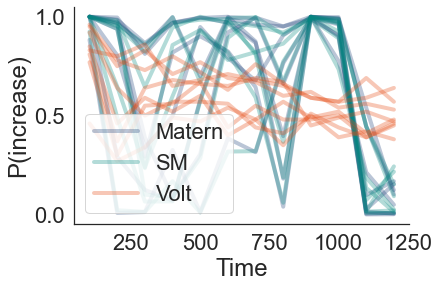

In [66]:
plt.plot(eval_times, torch.stack(matern_list).t(), alpha = 0.3, color = palette[0], 
         label = ["Matern", *[None]*(len(tckrs)-1)])
plt.plot(eval_times, torch.stack(sm_list).t(), alpha = 0.3, color = palette[2], 
         label = ["SM", *[None]*(len(tckrs)-1)])
plt.plot(eval_times, torch.stack(volt_list).t(), alpha = 0.3, color = palette[6], 
         label = ["Volt", *[None]*(len(tckrs)-1)])
plt.xlabel("Time")
plt.ylabel("P(increase)")
plt.legend()
sns.despine()

In [67]:
eval_times = list(range(0, y_list[0].shape[-1], 100))

In [68]:
prices = [y_list[i][np.array(eval_times)] for i in range(len(y_list))]

In [69]:
prices[0].shape

(13,)

In [70]:
from torch.distributions import Beta
from scipy.special import betainc

In [71]:
bought_func = lambda xs: betainc(17, 8, xs)

def value_func(vec, prices_at_time_y, base = 10000):
    portfolio_value = torch.zeros(12)
    portfolio_value[0] = base
    for i in range(11):
        price_of_stock = portfolio_value[i] * bought_func(vec)[i]
        amt_bought = price_of_stock / prices_at_time_y[i]
        cash_left = portfolio_value[i] - price_of_stock
        portfolio_value[i+1] = cash_left + amt_bought * prices_at_time_y[i+1]
    return portfolio_value

In [72]:
matern_values = torch.stack([value_func(pinc, price) for pinc, price in zip(matern_list, prices)])
sm_values = torch.stack([value_func(pinc, price) for pinc, price in zip(sm_list, prices)])
volt_values = torch.stack([value_func(pinc, price) for pinc, price in zip(volt_list, prices)])

In [73]:
matern_values.shape

torch.Size([8, 12])

In [74]:
hold_values = torch.stack([10000 / y[0] * torch.tensor(price[1:]) for y, price in zip(y_list, prices)])

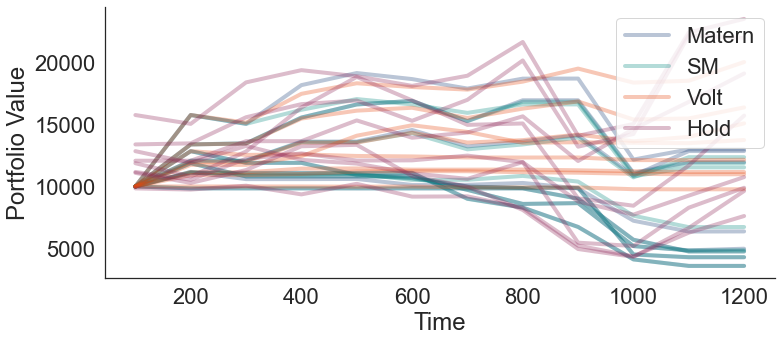

In [75]:
plt.figure(figsize = (12, 5))
plt.plot(eval_times[1:], matern_values.t(), alpha = 0.3, color = palette[0], 
         label = ["Matern", *[None]*(len(tckrs)-1)])
plt.plot(eval_times[1:], sm_values.t(), alpha = 0.3, color = palette[2], 
         label = ["SM", *[None]*(len(tckrs)-1)])
plt.plot(eval_times[1:], volt_values.t(), alpha = 0.3, color = palette[6], 
         label = ["Volt", *[None]*(len(tckrs)-1)])
plt.plot(eval_times[1:], hold_values.t(), alpha = 0.3, color = palette[4], 
         label = ["Hold", *[None]*(len(tckrs)-1)])
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
sns.despine()

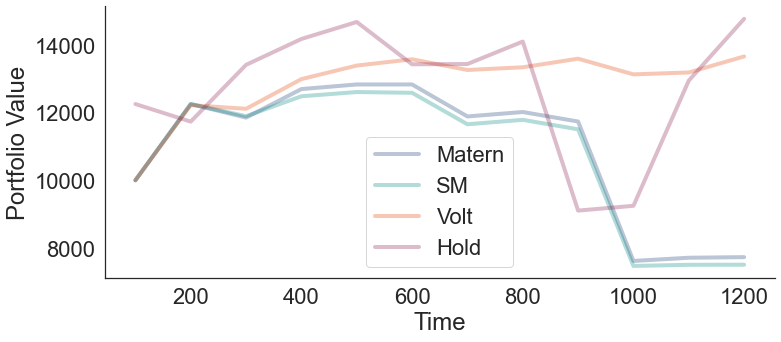

In [76]:
plt.figure(figsize = (12, 5))
plt.plot(eval_times[1:], matern_values.mean(0), alpha = 0.3, color = palette[0], 
         label="Matern")#, *[None]*(len(tckrs)-1)])
plt.plot(eval_times[1:], sm_values.mean(0), alpha = 0.3, color = palette[2], 
         label="SM")#, *[None]*(len(tckrs)-1)])
plt.plot(eval_times[1:], volt_values.mean(0), alpha = 0.3, color = palette[6], 
         label = "Volt")#, *[None]*(len(tckrs)-1)])
plt.plot(eval_times[1:], hold_values.mean(0), alpha = 0.3, color = palette[4], 
         label = "Hold")#, *[None]*(len(tckrs)-1)])
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
sns.despine()

In [77]:
def running_sharpe_ratio(vec):
    returns = vec - 10000
    std_returns = torch.stack([returns[..., :i].std(-1) for i in range(vec.shape[-1])]).t()
    # need avg return divided by sd of returns?
    return returns.cumsum(-1) / std_returns / torch.arange(vec.shape[-1])

In [78]:
%pdb

Automatic pdb calling has been turned OFF


In [79]:
matern_sharpe = running_sharpe_ratio(matern_values)
sm_sharpe = running_sharpe_ratio(sm_values)
volt_sharpe = running_sharpe_ratio(volt_values)
hold_sharpe = running_sharpe_ratio(hold_values)

In [80]:
# n = torch.arange(matern_sharpe.shape[-1])
# stddev = (n - 1) / (n * (n - 3))

stddev = matern_sharpe.shape[0]**(-0.5)

Text(0, 0.5, 'Sharpe Ratio')

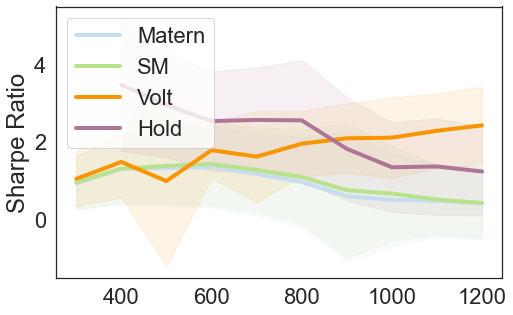

In [83]:
plt.figure(figsize = (8, 5))
plt.plot(eval_times[1:], matern_sharpe.mean(0), label = "Matern", color = palette[1])
plt.plot(eval_times[1:], sm_sharpe.mean(0), label = "SM", color = palette[3])
plt.plot(eval_times[1:], volt_sharpe.mean(0), label = "Volt", color = palette[7])
plt.plot(eval_times[1:], hold_sharpe.mean(0), label = "Hold", color = palette[5])

plt.fill_between(eval_times[1:], 
                 matern_sharpe.mean(0) - 2 * stddev * matern_sharpe.std(0),
                 matern_sharpe.mean(0) + 2 * stddev * matern_sharpe.std(0),
                 color = palette[1], 
                alpha = 0.1)
plt.fill_between(
    eval_times[1:], 
    sm_sharpe.mean(0) - 2 * stddev * sm_sharpe.std(0),
    sm_sharpe.mean(0) + 2 * stddev * sm_sharpe.std(0),
    color = palette[3],
    alpha = 0.1
)
plt.fill_between(
    eval_times[1:], 
    volt_sharpe.mean(0) - 2 * stddev * volt_sharpe.std(0),
    volt_sharpe.mean(0) + 2 * stddev * volt_sharpe.std(0),
    color = palette[7],
    alpha = 0.1
)
plt.fill_between(
    eval_times[1:], 
    hold_sharpe.mean(0) - 2 * stddev * hold_sharpe.std(0),
    hold_sharpe.mean(0) + 2 * stddev * hold_sharpe.std(0),
    color = palette[5],
    alpha = 0.1
)


plt.legend()
plt.ylabel("Sharpe Ratio")
# plt.ylim((0.5, 3))

In [91]:
import pandas as pd

In [92]:
df = pd.DataFrame({"x": np.repeat(np.arange(4),8), 
                   "y": torch.cat(
                       [matern_sharpe[..., -1], sm_sharpe[..., -1], volt_sharpe[..., -1], hold_sharpe[..., -1]])
                    })

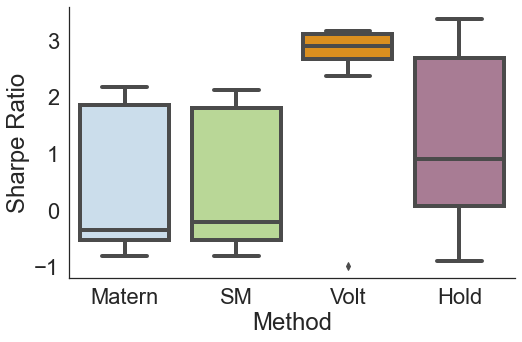

In [99]:
fig, ax = plt.subplots(figsize = (8, 5))
sns.boxplot(x="x", y="y", data=df, palette=[palette[1], palette[3], palette[7], palette[5]])
plt.ylabel("Sharpe Ratio")
plt.xlabel("Method")
ax.set_xticklabels(["Matern", "SM", "Volt", "Hold"])
sns.despine()
plt.savefig("sharpe_ratio.pdf", bbox_inches = "tight")